# OCR de Imagem com Modelo Treinado

Este notebook realiza OCR na imagem [ocr_test_image.png](../data/raw/ocr_test_image.png) utilizando o modelo treinado [modelo_ocr_simbolos.keras](../data/processed/modelo_ocr_simbolos.keras).

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import json
from pathlib import Path
import cv2

2025-10-18 14:45:52.007873: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 14:45:52.042675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 14:45:52.859713: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def find_project_root(markers=("pyproject.toml", ".git")) -> Path:
    """
    Descobre a raiz do projeto subindo diretórios até encontrar um marcador.
    """
    p = Path.cwd().resolve()
    for parent in [p, *p.parents]:
        if any((parent / m).exists() for m in markers):
            return parent
    return p

ROOT = find_project_root()
print(f"Raiz do projeto: {ROOT}")

Raiz do projeto: /mnt/x/01-projetos/11-work/11.32-doutorado/DL/projeto_elis


In [3]:
# Configurações
DATA_DIR = ROOT / "data"
MODEL_PATH = DATA_DIR / "processed" / "modelo_ocr_simbolos.keras"
IMAGE_PATH = DATA_DIR / "raw" / "ocr_test_image.png"
CLASS_NAMES_PATH = DATA_DIR / "raw" / "class_names.json"

IMG_HEIGHT = 64
IMG_WIDTH = 64

In [4]:
# Carrega o modelo treinado
print("Carregando modelo...")
model = tf.keras.models.load_model(MODEL_PATH)
print("✓ Modelo carregado com sucesso!")
model.summary()

Carregando modelo...


I0000 00:00:1760809553.784248   63212 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


✓ Modelo carregado com sucesso!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 149)            │        38,293 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,685,121 (25.50 MB)

 Trainable params: 2,228,373 (8.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,456,748 (17.00 MB)

In [5]:
# Carrega os nomes das classes
with open(CLASS_NAMES_PATH, 'r', encoding='utf-8') as f:
    class_names = json.load(f)
print(f"✓ {len(class_names)} classes carregadas")
print(f"Exemplos: {class_names[:5]}")

✓ 146 classes carregadas
Exemplos: ['U+0020', 'U+0021', 'U+0022', 'U+0023', 'U+0024']


In [6]:
def unicode_to_char(unicode_str: str) -> str:
    """
    Converte 'U+XXXX' para o caractere correspondente.
    Exemplo: 'U+0041' -> 'A'
    """
    try:
        codepoint = int(unicode_str.replace('U+', ''), 16)
        return chr(codepoint)
    except:
        return '?'

Carregando imagem: /mnt/x/01-projetos/11-work/11.32-doutorado/DL/projeto_elis/data/raw/ocr_test_image.png


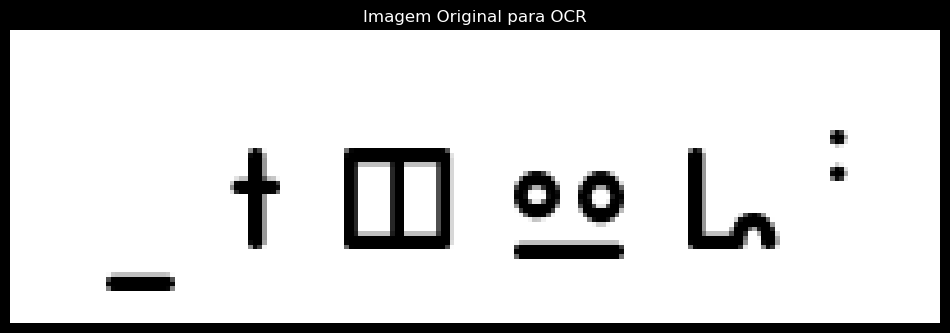

Dimensões: (203, 64)
Modo: L


In [7]:
# Carrega e exibe a imagem original
print(f"Carregando imagem: {IMAGE_PATH}")
original_image = Image.open(IMAGE_PATH)

plt.figure(figsize=(12, 4))
plt.imshow(original_image, cmap='gray')
plt.title('Imagem Original para OCR')
plt.axis('off')
plt.show()

print(f"Dimensões: {original_image.size}")
print(f"Modo: {original_image.mode}")

In [8]:
def preprocess_image_for_ocr(image: Image.Image) -> np.ndarray:
    """
    Pré-processa a imagem para OCR:
    - Converte para escala de cinza
    - Aplica threshold para binarização
    - Inverte cores se necessário (fundo branco, texto preto)
    """
    # Converte para escala de cinza
    if image.mode != 'L':
        image = image.convert('L')

    # Converte para numpy array
    img_array = np.array(image)

    # Aplica threshold adaptativo para melhor binarização
    img_binary = cv2.adaptiveThreshold(
        img_array, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Verifica se precisa inverter (modelo espera fundo branco, texto preto)
    # Se a média é baixa, a imagem está com fundo escuro
    if np.mean(img_binary) < 127:
        img_binary = 255 - img_binary

    return img_binary

Pré-processando imagem...


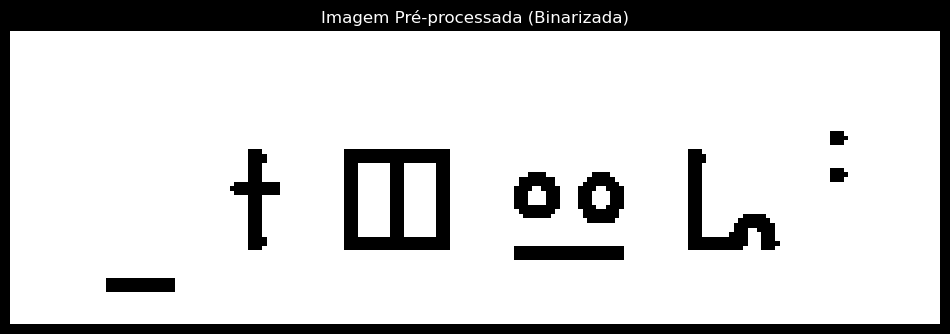

In [9]:
# Pré-processa a imagem
print("Pré-processando imagem...")
processed_image = preprocess_image_for_ocr(original_image)

plt.figure(figsize=(12, 4))
plt.imshow(processed_image, cmap='gray')
plt.title('Imagem Pré-processada (Binarizada)')
plt.axis('off')
plt.show()

In [31]:
def segment_characters(image_array: np.ndarray) -> list:
    """
    Segmenta caracteres individuais da imagem usando contornos.
    Retorna lista de (bbox, imagem_segmentada).
    """
    # Encontra contornos
    contours, _ = cv2.findContours(
        255 - image_array,  # Inverte para findContours
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    # Filtra e ordena contornos da esquerda para direita
    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Filtra contornos muito pequenos (ruído)
        if w > 1 and h > 1:
            char_regions.append((x, y, w, h))

    # Ordena da esquerda para direita
    char_regions = sorted(char_regions, key=lambda r: r[0])

    # Extrai as regiões
    segmented_chars = []
    for (x, y, w, h) in char_regions:
        # Adiciona padding
        padding = 5
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(image_array.shape[1], x + w + padding)
        y2 = min(image_array.shape[0], y + h + padding)

        char_img = image_array[y1:y2, x1:x2]
        segmented_chars.append(((x, y, w, h), char_img))

    return segmented_chars

Segmentando caracteres...
✓ 9 caracteres detectados


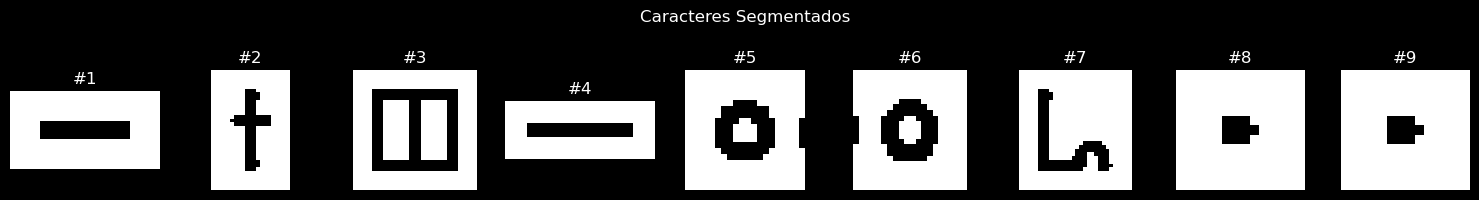

In [32]:
# Segmenta caracteres
print("Segmentando caracteres...")
segmented_chars = segment_characters(processed_image)
print(f"✓ {len(segmented_chars)} caracteres detectados")

# Visualiza caracteres segmentados
if len(segmented_chars) > 0:
    n_chars = len(segmented_chars)
    cols = min(10, n_chars)
    rows = (n_chars + cols - 1) // cols

    plt.figure(figsize=(15, 2 * rows))
    for i, (bbox, char_img) in enumerate(segmented_chars):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(char_img, cmap='gray')
        plt.title(f'#{i+1}')
        plt.axis('off')
    plt.suptitle('Caracteres Segmentados')
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Nenhum caractere foi detectado!")

In [33]:
def prepare_char_for_prediction(char_image: np.ndarray) -> np.ndarray:
    """
    Prepara um caractere segmentado para predição:
    - Redimensiona para 64x64
    - Centraliza o caractere
    - Adiciona dimensões do batch e canal
    """
    # Cria canvas quadrado branco
    size = max(char_image.shape)
    canvas = np.ones((size, size), dtype=np.uint8) * 255

    # Centraliza o caractere
    y_offset = (size - char_image.shape[0]) // 2
    x_offset = (size - char_image.shape[1]) // 2
    canvas[y_offset:y_offset+char_image.shape[0],
           x_offset:x_offset+char_image.shape[1]] = char_image

    # Redimensiona para 64x64
    resized = cv2.resize(canvas, (IMG_WIDTH, IMG_HEIGHT),
                        interpolation=cv2.INTER_LANCZOS4)

    # Adiciona dimensões: (1, 64, 64, 1)
    # IMPORTANTE: NÃO normalizar aqui - o modelo tem Rescaling(1./255) interno
    prepared = resized.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)

    return prepared

In [34]:
# Realiza OCR em cada caractere
print("\nRealizando OCR...")
results = []

for i, (bbox, char_img) in enumerate(segmented_chars):
    # Prepara para predição
    input_array = prepare_char_for_prediction(char_img)

    # Predição
    predictions = model.predict(input_array, verbose=0)
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx]

    # Converte para caractere
    unicode_class = class_names[predicted_idx]
    character = unicode_to_char(unicode_class)

    results.append({
        'index': i,
        'bbox': bbox,
        'unicode': unicode_class,
        'character': character,
        'confidence': confidence,
        'image': char_img
    })

    print(f"Caractere {i+1}: '{character}' ({unicode_class}) - Confiança: {confidence:.4f}")

# Texto reconhecido
recognized_text = ''.join([r['character'] for r in results])
print(f"\n{'='*60}")
print(f"TEXTO RECONHECIDO: {recognized_text}")
print(f"{'='*60}")


Realizando OCR...
Caractere 1: 't' (U+0074) - Confiança: 0.9739
Caractere 2: 'h' (U+0068) - Confiança: 1.0000
Caractere 3: 'z' (U+007A) - Confiança: 1.0000
Caractere 4: 't' (U+0074) - Confiança: 0.6558
Caractere 5: '4' (U+0034) - Confiança: 0.7682
Caractere 6: '4' (U+0034) - Confiança: 0.9827
Caractere 7: 'Ì' (U+00CC) - Confiança: 1.0000
Caractere 8: 'k' (U+006B) - Confiança: 1.0000
Caractere 9: 'k' (U+006B) - Confiança: 1.0000

TEXTO RECONHECIDO: thzt44Ìkk


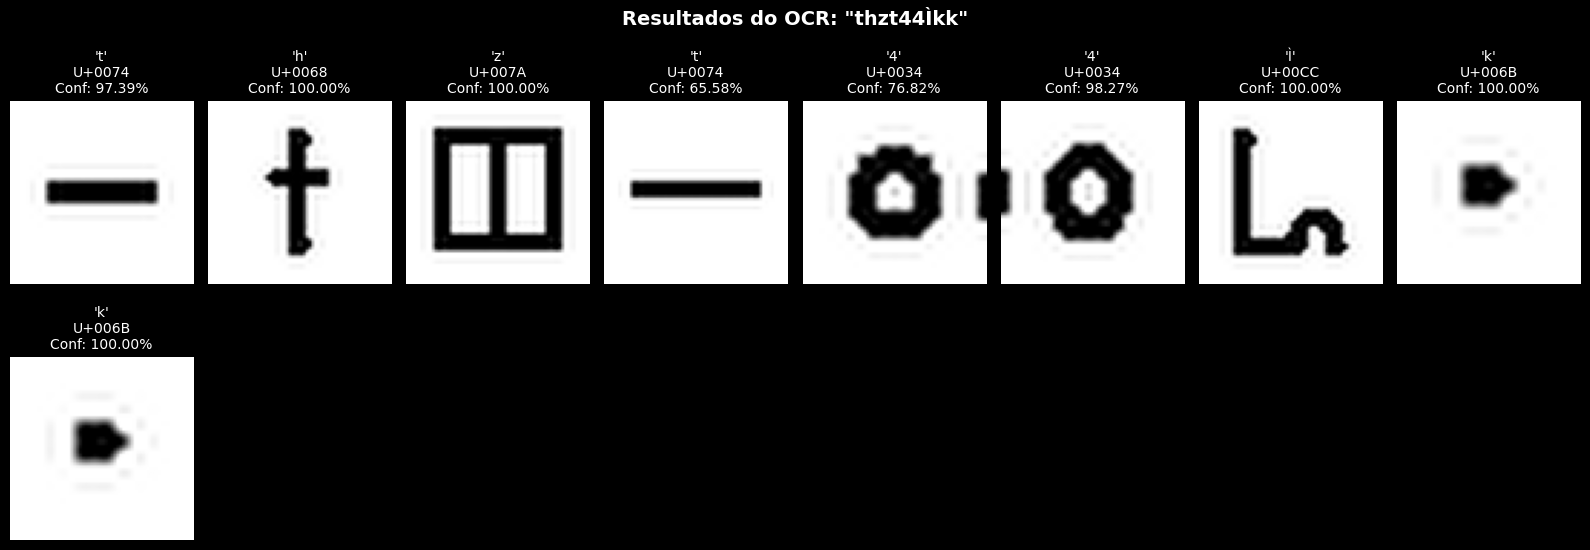

In [35]:
# Visualização detalhada dos resultados
if len(results) > 0:
    n_results = len(results)
    cols = min(8, n_results)
    rows = (n_results + cols - 1) // cols

    plt.figure(figsize=(16, 3 * rows))
    for i, result in enumerate(results):
        # Imagem preparada para o modelo
        prepared = prepare_char_for_prediction(result['image'])

        plt.subplot(rows, cols, i + 1)
        plt.imshow(prepared.squeeze(), cmap='gray')
        plt.title(
            f"'{result['character']}'\n"
            f"{result['unicode']}\n"
            f"Conf: {result['confidence']:.2%}",
            fontsize=10
        )
        plt.axis('off')

    plt.suptitle(
        f'Resultados do OCR: "{recognized_text}"',
        fontsize=14, fontweight='bold'
    )
    plt.tight_layout()
    plt.show()

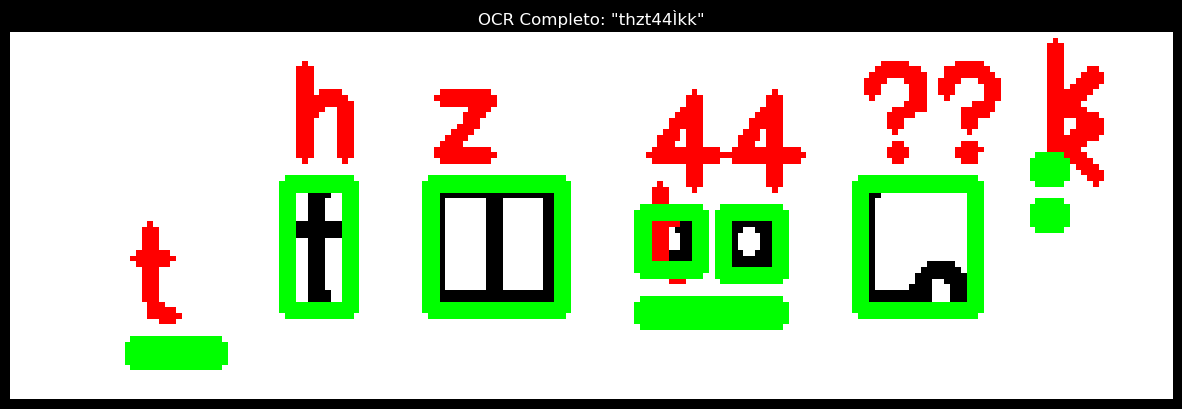

In [36]:
# Imagem com anotações
annotated = cv2.cvtColor(processed_image.copy(), cv2.COLOR_GRAY2RGB)

for result in results:
    x, y, w, h = result['bbox']
    # Desenha retângulo
    cv2.rectangle(annotated, (x, y), (x+w, y+h), (0, 255, 0), 2)
    # Adiciona texto
    cv2.putText(
        annotated, result['character'],
        (x, y-5), cv2.FONT_HERSHEY_SIMPLEX,
        0.7, (255, 0, 0), 2
    )

plt.figure(figsize=(15, 5))
plt.imshow(annotated)
plt.title(f'OCR Completo: "{recognized_text}"')
plt.axis('off')
plt.show()

In [37]:
# Salva resultados
output_data = {
    'recognized_text': recognized_text,
    'total_characters': len(results),
    'average_confidence': float(np.mean([r['confidence'] for r in results])),
    'characters': [
        {
            'position': i,
            'character': r['character'],
            'unicode': r['unicode'],
            'confidence': float(r['confidence']),
            'bbox': r['bbox']
        }
        for i, r in enumerate(results)
    ]
}

output_path = DATA_DIR / "processed" / "ocr_results.json"
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, ensure_ascii=False, indent=2)

print(f"\n✓ Resultados salvos em: {output_path}")
print(f"\nResumo:")
print(f"  Texto: {recognized_text}")
print(f"  Caracteres: {len(results)}")
print(f"  Confiança média: {output_data['average_confidence']:.2%}")


✓ Resultados salvos em: /mnt/x/01-projetos/11-work/11.32-doutorado/DL/projeto_elis/data/processed/ocr_results.json

Resumo:
  Texto: thzt44Ìkk
  Caracteres: 9
  Confiança média: 93.12%
